## 2021389
## Lab_07

## Importing Necessary Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


<Axes: xlabel='Date'>

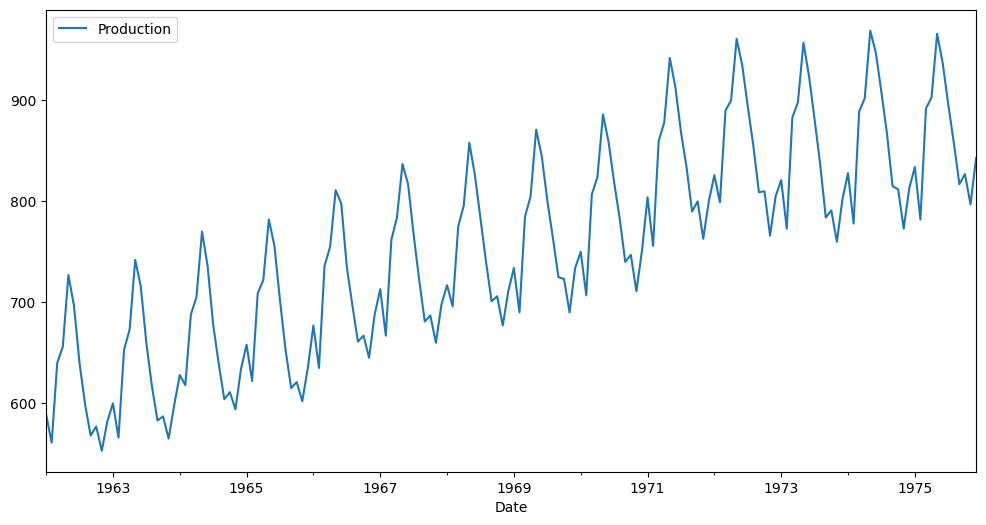

In [5]:
df.plot(figsize=(12,6))

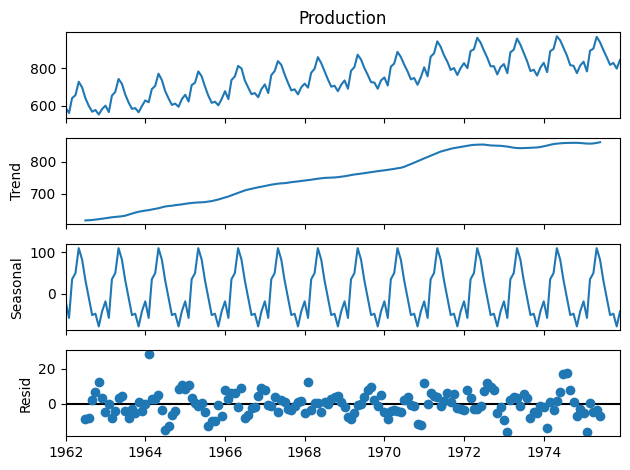

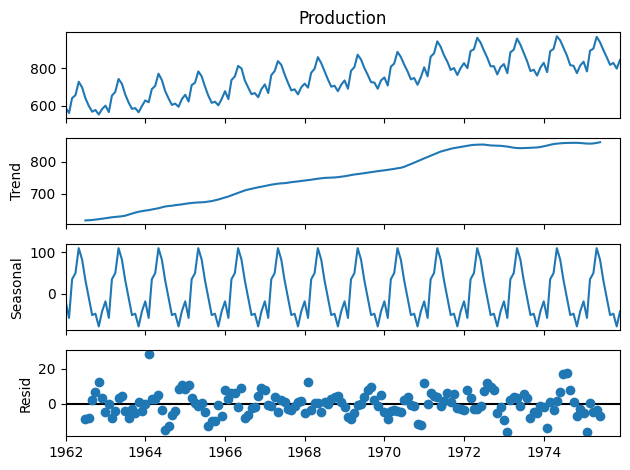

In [7]:
results = seasonal_decompose(df['Production'])
results.plot()

In [8]:
len(df)

168

In [9]:
train = df.iloc[:156]
test = df.iloc[156:]

In [12]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [13]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [17]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [19]:
X.shape

(1, 3, 1)

In [20]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [22]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 4s 14ms/step - loss: 0.0373
Epoch 2/50
144/144 [==============================] - 2s 16ms/step - loss: 0.0193
Epoch 3/50
144/144 [==============================] - 2s 13ms/step - loss: 0.0172
Epoch 4/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0113
Epoch 5/50
144/144 [==============================] - 2s 10ms/step - loss: 0.0070
Epoch 6/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0065
Epoch 7/50
144/144 [==============================] - 3s 24ms/step - loss: 0.0060
Epoch 8/50
144/144 [==============================] - 3s 23ms/step - loss: 0.0044
Epoch 9/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0077
Epoch 10/50
144/144 [==============================] - 2s 10ms/step - loss: 0.0052
Epoch 11/50
144/144 [==============================] - 3s 17ms/step - loss: 0.0047
Epoch 12/50
144/144 [==============================] - 3s 20ms/step - loss: 0.0036
Epoch 13/50
1

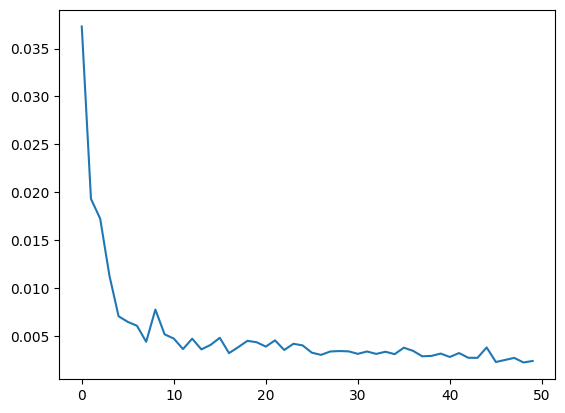

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
last_train_batch = scaled_train[-12:]

In [27]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 1s/step


array([[0.6733817]], dtype=float32)

In [29]:
scaled_test[0]

array([0.67548077])

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 42ms/step


In [31]:
test_predictions

[array([0.6733817], dtype=float32),
 array([0.6911946], dtype=float32),
 array([0.8416686], dtype=float32),
 array([0.9205974], dtype=float32),
 array([1.0073678], dtype=float32),
 array([1.0048364], dtype=float32),
 array([0.9467685], dtype=float32),
 array([0.84892666], dtype=float32),
 array([0.7448874], dtype=float32),
 array([0.6944795], dtype=float32),
 array([0.6538579], dtype=float32),
 array([0.6861984], dtype=float32)]

In [32]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

<ipython-input-34-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

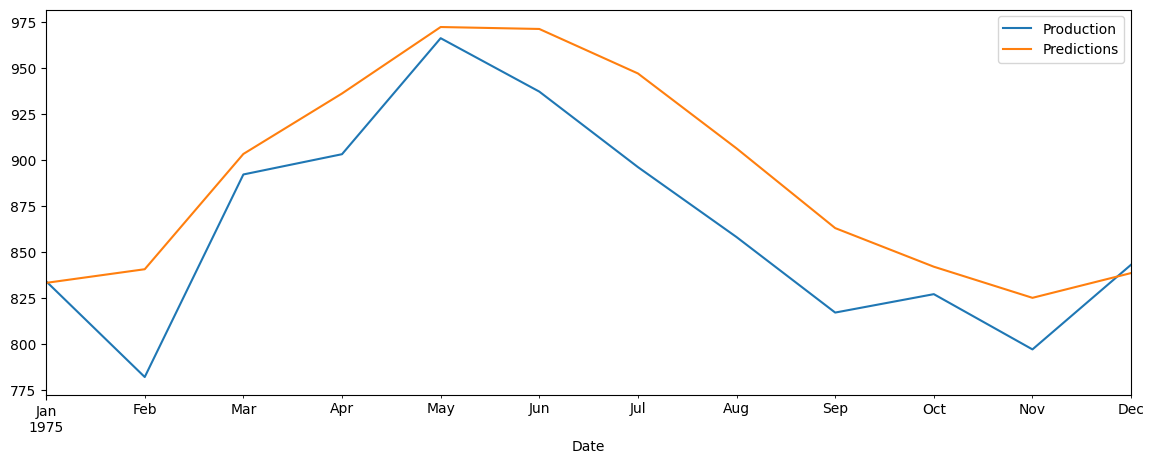

In [35]:
test.plot(figsize=(14,5))

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

33.995400760993526
